# Vision transformer implementation

Dans ce notebook, nous allons implémenter le *vision transformer* et la tester le petit dataset CIFAR-10. L'implémentation reprend des éléments du notebook 2 "GptFromScratch" donc il est nécessaire de les faire dans l'ordre. 

L'implémentation se base sur le papier [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/pdf/2010.11929). 

Voici la figure importante de cet article que l'on va implémenter petit à petit : 

<img src="images/ViT.png" alt="transformer" width="700"/> 


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

# Detection automatique du GPU
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print(f"using device: {device}")

using device: cpu


## Reprise du code précédent 

Dans un premier temps, on va reprendre le code du [notebook 2 de ce cours](https://github.com/SimonThomine/CoursDeepLearning/blob/main/07_Transformers/02_GptFromScratch.ipynb) en y apportant quelques modifications.  

### Couche de self-attention

Si vous vous souvenez bien, dans le notebook 2 nous avons implémenté la couche *masked multi-head attention* pour entraîner un *transformer* de type *decoder*. Pour les images, on veut un *transformer* de type *encoder*, il va donc falloir changer notre implémentation.   
C'est en fait très simple : on avait une multiplication par une matrice triangulaire inférieure pour masquer le "futur" dans le *decoder* alors que dans l'*encoder* on ne veut pas masquer le futur, il suffit donc de supprimer cette multiplication par la matrice.

Voici le code python ajusté : 

In [2]:
class Head_enc(nn.Module):
    """ Couche de self-attention unique """

    def __init__(self, head_size,n_embd,dropout=0.2):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # Le * C**-0.5 correspond à la normalisation par la racine de head_size
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        # On a supprimer le masquage du futur
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

### Multi-head self-attention

Pour avoir plusieurs *head*, on va simplement reprendre notre classe du notebook 2 mais en utilisant *Head_enc* au lieu de *Head* : 

In [3]:
class MultiHeadAttention(nn.Module):
    """ Plusieurs couches de self attention en parallèle"""

    def __init__(self, num_heads, head_size,n_embd,dropout):
        super().__init__()
        # Création de num_head couches head_enc de taille head_size
        self.heads = nn.ModuleList([Head_enc(head_size,n_embd,dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

### Feed forward layer

On réutilise également notre implémentation de la *feed forward layer*, on change juste la fonction d'activation *ReLU* en *GeLU* comme décrit dans le papier : 

In [4]:
class FeedFoward(nn.Module):

    def __init__(self, n_embd,dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

### Transformer encoder block

Et enfin, on peut construire notre *block* de *transformer* encorder correspondant à celui que l'on voit sur la figure plus haut : 

In [5]:
class TransformerBlock(nn.Module):
    """ Block transformer"""

    def __init__(self, n_embd, n_head,dropout=0.):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size,n_embd,dropout)
        self.ffwd = FeedFoward(n_embd,dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

**Note** : Ici, je suis allé très rapidement sur ces couches car elles ont été implémentées en détail dans le notebook 2. Je vous invite à vous y référer en cas d'incompréhension. 

## Implémentation du réseau

Nous allons maintenant faire l'implémentation du réseau pas à pas.

### Séparation de l'image en patch 

La première étape décrite dans la papier est la division de l'image en *patch* :    
Chaque image est découpé en $N$ patchs de taille $p \times p$ puis les *patchs* sont ensuite applatis (*flatten*).   
On passe d'une dimension de l'image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ à une séquence de *patch* $\mathbf{x}_p \in \mathbb{R}^{N \times (P^2 \cdot C)}$.


<img src="images/patchs.png" alt="patchs" width="400"/> 


Pour réaliser cela, nous allons récuperer une image du dataset CIFAR-10 comme exemple ce qui nous permettra de visualiser si notre code fonctionne.

In [6]:
transform=T.ToTensor() # Pour convertir les éléments en tensor torch directement
dataset = datasets.CIFAR10(root='./../data', train=True, download=True,transform=transform)

Files already downloaded and verified


Récuperons une simple image de ce dataset pour faire nos magouilles :

torch.Size([3, 32, 32])


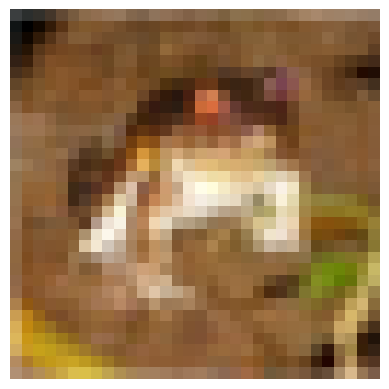

In [7]:
image=dataset[0][0]
print(image.shape)
plt.imshow(dataset[0][0].permute(1,2,0).numpy())
plt.axis("off")
plt.show()

Une magnifique grenouille !

Pour choisir la dimension d'un *patch*, il faut prendre une dimension divisible par 32. Prenons par exemple $8 \times 8$ ce qui nous fera 16 *patchs*. Laissons cette valeur comme étant un paramètre que l'on peut choisir.

Dans un premier temps, on peut penser qu'il faut faire deux boucles sur la largeur et la hauteur en récuperant un patch à chaque fois de cette manière : 

In [8]:
patch_size = 8
list_of_patches = []
for i in range(0,image.shape[1],patch_size):
    for j in range(0,image.shape[2],patch_size):
        patch=image[:,i:i+patch_size,j:j+patch_size]
        list_of_patches.append(patch)
tensor_patches = torch.stack(list_of_patches)
print(tensor_patches.shape)

torch.Size([16, 3, 8, 8])


Ce n'est pas du tout efficace en terme de code. Avec pytorch, on peut en fait faire beaucoup plus simple avec *view()* et *unfold()*. Cette étape est un peu compliqué mais nécessaire pour des raisons de continuité en mémoire pour que la fonction *view()* fonctionne correctement. Faire simplement ```patches = image.view(-1, C, patch_size, patch_size)``` ne fonctionnerait pas (vous pouvez essayer pour vous en assurer).

In [9]:
C,H,W = image.shape
# On utilise la fonction unfold pour découper l'image en patch contigus
# Le premier unfold découpe la première dimension (H) en ligne
# Le deuxième unfold découpe chacune des lignes en patch_size colonnes 
# Ce qui donne une image de taille (C, H//patch_size, W//patch_size,patch_size, patch_size)
patches = image.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
# Permute pour avoir les dimensions dans le bon ordre
patches = patches.permute(1, 2, 0, 3, 4).contiguous()
patches = patches.view(-1, C, patch_size, patch_size)
print(patches.shape)
# On peut vérifier que ça fait bien la même chose
print((patches==tensor_patches).all())

torch.Size([16, 3, 8, 8])
tensor(True)


Maitenant on va applatir nos *patchs* pour avoir notre résultat final.

In [10]:
nb_patches = patches.shape[0]
print(nb_patches)
patches_flat = patches.flatten(1, 3)
print(patches_flat.shape)

16
torch.Size([16, 192])


Définissons une fonction pour faire ces transformations : 

In [11]:
# La fonction a été modifiée pour prendre en compte le batch
def image_to_patches(image, patch_size):
    # On rajoute une dimension pour le batch
    B,C,_,_ = image.shape
    patches = image.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.permute(0,2, 3, 1, 4, 5).contiguous()
    patches = patches.view(B,-1, C, patch_size, patch_size)
    patches_flat = patches.flatten(2, 4)
    return patches_flat


Nous y sommes ! La première étape est terminée :)

### Projection linéaire des patchs 

Il est temps de passer à la deuxième étape qui est la projection linéaire des *patchs* dans un espace latent.

<img src="images/linearproj.png" alt="linearproj" width="400"/> 


Cette étape est l'équivalent de l'étape de conversion des *tokens* à l'aide la table d'*embedding*. Cette fois-ci, on va convertir nos *patchs* applatis en vecteur de dimension fixe pour que ces vecteurs puissent être traité par le *transformer*. Définissons notre dimension d'*embedding* et notre couche de projection :

In [12]:
n_embd = 64
proj_layer = nn.Linear(C*patch_size*patch_size, n_embd)

C'est tout, ce n'est pas l'étape la plus compliquée.

### Embedding de position et class token

Passons à la dernière étape avant les couches *transformers* (qui sont déjà implémentées).
Cette étape contient en fait 2 étapes distinctes :
- **L'ajout d'un embedding de position** : comme dans le GPT, le transformer n'a pas d'information préalable sur la position du patch dans l'image. Pour cela, on va simplement ajouter un *embedding* dédié à cela qui permettra au réseau d'avoir une notion de position relative des *patchs*.
- **L'ajout d'un class token** : Cette étape est nouvelle car elle n'était pas nécessaire dans GPT. L'idée vient en fait de [BERT](https://arxiv.org/pdf/1810.04805) et est une technique pour faire de la classification à l'aide d'un *transformer* sans avoir à spécifier de taille de séquence fixe. Sans *class token*, pour obtenir notre classification, on aurait besoin soit de coller un réseau fully connected à l'ensemble des sorties du *transformers* (ce qui va imposer une taille de séquence fixe) ou de coller un réseau fully connected à une sortie du *transformer* choisie au hasard (une sortie correspond à un *patch*, mais alors comment choisir ce *patch* sans biais ?). L'ajout du *class token* permet de répondre à ce problème en ajoutant un *token* dédié spécifiquement à la classification. 

**Note** : Pour pour les CNNs, une manière d'éviter le problème de la dimension fixe de l'entrée est d'utiliser un *global average pooling* en sortie (couche de *pooling* avec taille de sortie fixe). Cette technique peut aussi être utilisée pour un *vision transformer* à la place du *class token*.


<img src="images/embedclass.png" alt="embedclass" width="400"/> 


In [13]:
# Pour le positional encoding, +1 pour le cls token
pos_emb = nn.Embedding(nb_patches+1, n_embd)
# On ajoute un token cls
cls_token = torch.zeros(1, 1, n_embd)
# On ajoutera ce token cls au début de chaque séquence

### Réseau fully connected de classification

Maintenant, passons à la fin du ViT, c'est à dire le réseau MLP de classification. Si vous avez suivi l'intêret du *class token*, vous comprenez que ce réseau de classification prend en entrée uniquement ce *token* pour nous sortir la classe prédite. 

<img src="images/fcn.png" alt="fcn" width="400"/>

A nouveau, c'est encore une implémentation assez simple. Dans l'article, ils disent qu'ils utilisent un réseau d'une couche cachée pour l'entraînement et uniquement une couche pour un *fine-tuning* (voir cours 10 pour des précisions sur le fine tuning). Par soucis de simplicité, nous utilisons une seule couche linéaire pour projeter le class *token* de sortie dans la dimension du nombre de classes.

In [14]:
classi_head = nn.Linear(n_embd, 10)

Nous disposons maitenant de tous les éléments pour construire notre ViT et l'entraîner ! 

### Création du modèle ViT

On peut maintenant rassembler les morceaux et créer notre *vision transformer*.

In [15]:
class ViT(nn.Module):
    def __init__(self, n_embed,patch_size,C,n_head,n_layer,nb_patches,dropout=0.) -> None:
        super().__init__()
        self.proj_layer = nn.Linear(C*patch_size*patch_size, n_embed)
        self.pos_emb = nn.Embedding(nb_patches+1, n_embed)
        # Permet de créer cls_token comme un paramètre du réseau
        self.register_parameter(name='cls_token', param=torch.nn.Parameter(torch.zeros(1, 1, n_embed)))
        self.transformer=nn.Sequential(*[TransformerBlock(n_embed, n_head,dropout) for _ in range(n_layer)])
        self.classi_head = nn.Linear(n_embed, 10)
    
    def forward(self,x):
        B,_,_,_=x.shape
        # On découpe l'image en patch et on les applatit
        x = image_to_patches(x, patch_size)
        # On projette dans la dimension n_embed
        x = self.proj_layer(x)
        # On ajoute le token cls
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        # On ajoute le positional encoding
        pos_emb = self.pos_emb(torch.arange(x.shape[1], device=x.device))
        x = x + pos_emb
        # On applique les blocks transformer
        x = self.transformer(x)
        # On récupère le token cls
        cls_tokens = x[:, 0]
        # On applique la dernière couche de classification
        x = self.classi_head(cls_tokens)
        return x        

## Entrainement de notre ViT

On va entraîner notre modèle ViT sur le dataset CIFAR-10. A noter que les paramètres que nous avons défini sont adaptés pour des images de petites taille (*n_embed* et *patch_size*). Pour traiter des images plus grande, il faudra adapter ces paramètres. Le code fonctionne avec des tailles différentes dans que la taille de l'image est divisible par le taille du *patch*. 

### Chargement des datasets : train, val et test

Chargons le dataset CIFAR-10 et créons nos dataloaders : 

**Note** : Vous pouvez séléctionner une sous-partie du dataset pour accélerer l'entraînement.

In [16]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# Transformation des données, normalisation et transformation en tensor pytorch
transform = T.Compose([T.ToTensor(),T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Téléchargement et chargement du dataset
dataset = datasets.CIFAR10(root='./../data', train=True,download=True, transform=transform)
testdataset = datasets.CIFAR10(root='./../data', train=False,download=True, transform=transform)
print("taille d'une image : ",dataset[0][0].shape)


#Création des dataloaders pour le train, validation et test
train_dataset, val_dataset=torch.utils.data.random_split(dataset, [0.8,0.2])
print("taille du train dataset : ",len(train_dataset))
print("taille du val dataset : ",len(val_dataset))
print("taille du test dataset : ",len(testdataset))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16,shuffle=True, num_workers=2)
val_loader= torch.utils.data.DataLoader(val_dataset, batch_size=16,shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testdataset, batch_size=16,shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
taille d'une image :  torch.Size([3, 32, 32])
taille du train dataset :  40000
taille du val dataset :  10000
taille du test dataset :  10000


### Hyperparamètres et création du modèle

On va maintenant définir nos hyperparamètres d'entraînement et pour les spécificités du modèle : 

In [17]:
patch_size = 8
nb_patches = (32//patch_size)**2
n_embed = 64
n_head = 4
n_layer = 4
epochs = 10
C=3 # Nombre de canaux
lr = 1e-3
model = ViT(n_embed,patch_size,C,n_head,n_layer,nb_patches).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### Entrainement du modèle

Il est finalement temps d'entraîner notre modèle !

In [18]:
for epoch in range(epochs):
    model.train()
    loss_train = 0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = F.cross_entropy(output, labels)
        loss_train += loss.item()
        loss.backward()
        optimizer.step()
        
    model.eval()
    correct = 0
    total = 0
    loss_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss_val += F.cross_entropy(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch}, loss train {loss_train/len(train_loader)}, loss val {loss_val/len(val_loader)},précision {100 * correct / total}")

Epoch 0, loss train 1.6522698682546615, loss val 1.4414834783554078,précision 47.97
Epoch 1, loss train 1.3831321718215943, loss val 1.3656272639274598,précision 50.69
Epoch 2, loss train 1.271412028503418, loss val 1.2726070711135864,précision 55.17
Epoch 3, loss train 1.1935315937042237, loss val 1.2526390438556672,précision 55.52
Epoch 4, loss train 1.1144725002408027, loss val 1.2377954412460328,précision 55.66
Epoch 5, loss train 1.0520227519154548, loss val 1.2067877051830291,précision 56.82
Epoch 6, loss train 0.9839000009179115, loss val 1.2402711957931518,précision 56.93
Epoch 7, loss train 0.9204218792438507, loss val 1.2170260044574737,précision 58.23
Epoch 8, loss train 0.853291154640913, loss val 1.2737546770095824,précision 57.65
Epoch 9, loss train 0.7962572723925113, loss val 1.2941821083545684,précision 58.26


L'entraînement s'est bien passé, on obtient une précision de 58% sur les données de validation. Regardons maintenant nos résultats sur les données de test :

In [19]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Précision {100 * correct / total}")

Précision 58.49


La précision est du même ordre sur les données de test ! 

**Note** : Ce résultat peut paraitre assez médiocre mais il ne faut pas oublier que nous utilisons un petit *transformer* entraîné sur peu d'epochs. Vous pouvez essayer d'améliorer ce résultat en jouant sur les hyperparamètres.

**Note2** : Les auteurs du papier précisent que le *transformer* n'a pas de "inductive bias" sur les images contrairement aux CNN et cela provient de l'architecture. Les couches d'un CNN sont invariantes par translation et capturent le voisinage de chaque pixel tandis que les *transformers* utilisent principalement l'information globale. En pratique, on constate que sur des "petits" datasets (jusqu'à 1 million d'images), les CNN performent mieux mais pour des plus grosses quantité de données, les *transformers* sont plus performants. 